# **04 - LSTM Forecasting of Realized Volatility**

This notebook builds a univariate LSTM model to forecast the 21-day realized volatility series `rv_21`.

The goal of this notebook is to check whether a simple univariate LSTM model can capture meaningful structure in the 21-day realized volatility series.  <br>
The intention is not to find the best possible neural network or to tune the model for peak performance.  <br>
The architecture, window length, and training parameters are kept fixed and modest so that the results stay directly comparable with the GARCH model and the earlier baseline forecasts.  <br>
This allows us to evaluate how a basic sequence model behaves when applied to volatility dynamics without introducing additional complexity through hyperparameter search.



## **Imports and Configuration**

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(42)
np.random.seed(42)

from pathlib import Path

plt.style.use("seaborn-v0_8")

# Device detection
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## **Load Data and Basic Diagnostics**

We load the exact same dataset used for GARCH modeling.  <br>
This preserves the same train-test split and target definition.

In [67]:
data_path = Path("../data/processed/modeling_dataset.csv")
#data_path = "/content/modeling_dataset.csv"
df = pd.read_csv(data_path)

df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

print(df.head(5))

print("\nColumns:", df.columns.tolist())
print("Number of rows:", len(df))

print("\nMissing values per column:")
print(df.isna().sum())


        Date         Open         High          Low        Close    Adj Close  \
0 2000-02-02  1409.280029  1420.609985  1403.489990  1409.119995  1409.119995   
1 2000-02-03  1409.119995  1425.780029  1398.520020  1424.969971  1424.969971   
2 2000-02-04  1424.969971  1435.910034  1420.630005  1424.369995  1424.369995   
3 2000-02-07  1424.369995  1427.150024  1413.329956  1424.239990  1424.239990   
4 2000-02-08  1424.239990  1441.829956  1424.239990  1441.719971  1441.719971   

       Volume  log_return     rv_21  
0  1038600000   -0.000114  0.016190  
1  1146500000    0.011185  0.013915  
2  1045100000   -0.000421  0.013915  
3   918100000   -0.000091  0.013916  
4  1047700000    0.012198  0.012880  

Columns: ['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'log_return', 'rv_21']
Number of rows: 6496

Missing values per column:
Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
log_return    0
rv_21      

Plot the target series to visually confirm the volatility pattern.

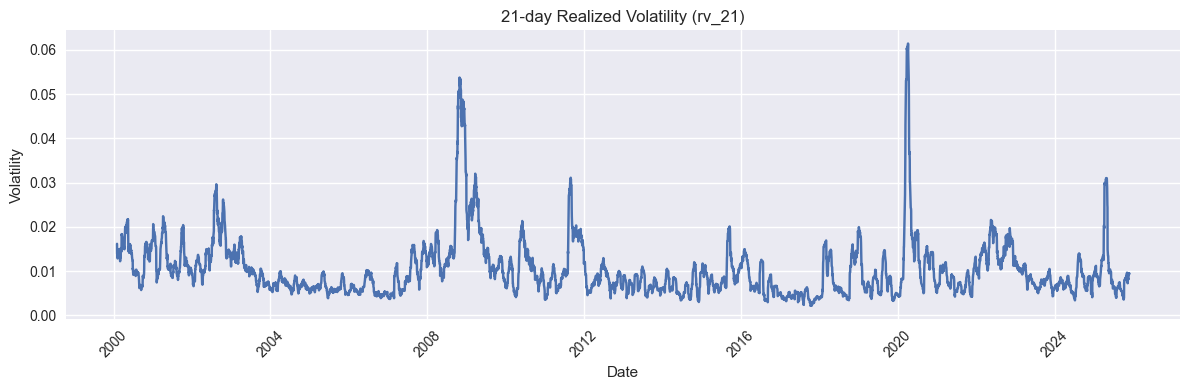

In [68]:
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["rv_21"])
plt.title("21-day Realized Volatility (rv_21)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## **Train-Test Split**

We use the same split ratio as previous models for consistency and fair comparison.

In [69]:
split_ratio = 0.8
split_index = int(len(df) * split_ratio)

train = df.iloc[:split_index].copy()
test = df.iloc[split_index:].copy()

print("Train period:", train["Date"].min(), "to", train["Date"].max())
print("Test period:", test["Date"].min(), "to", test["Date"].max())
print("Train observations:", len(train))
print("Test observations:", len(test))

# Extract the rv_21 series for reference
y_train_full = train["rv_21"].values.astype(float)
y_test_full = test["rv_21"].values.astype(float)
y_full = df["rv_21"].values.astype(float)

print("Train target length:", len(y_train_full))
print("Test target length:", len(y_test_full))


Train period: 2000-02-02 00:00:00 to 2020-09-25 00:00:00
Test period: 2020-09-28 00:00:00 to 2025-11-28 00:00:00
Train observations: 5196
Test observations: 1300
Train target length: 5196
Test target length: 1300


## **Sequence Preparation**

We scale the target `rv_21` using only the training period to avoid leakage, then apply the same transformation to the full series.  <br>
Sequences are then created on the scaled full series.


In [70]:
window = 30 # number of past days used to predict the next one

scaler = MinMaxScaler()
scaler.fit(y_train_full.reshape(-1, 1))

y_full_scaled = scaler.transform(y_full.reshape(-1, 1)).flatten()
print("Scaled series length:", len(y_full_scaled))

Scaled series length: 6496


Create sliding windows and labels:
* Each sequence contains `window` past values of scaled `rv_21`.
* Each label is the next scaled value.

In [71]:
sequences = []
labels = []

for i in range(len(y_full_scaled) - window):
    seq = y_full_scaled[i:i + window]
    lbl = y_full_scaled[i + window]
    sequences.append(seq)
    labels.append(lbl)

sequences = np.array(sequences)
labels = np.array(labels)

print("Sequences shape:", sequences.shape)  # (num_samples, window)
print("Labels shape:", labels.shape)        # (num_samples,)


Sequences shape: (6466, 30)
Labels shape: (6466,)


Reshape sequences to the format expected by PyTorch LSTM:  <br>
(batch_size, sequence_length, num_features).

In [72]:
sequences = sequences.reshape(sequences.shape[0], window, 1)
print("Sequences reshaped for LSTM:", sequences.shape)


Sequences reshaped for LSTM: (6466, 30, 1)


## **Train-Test Split at Sequence Level**

Labels for sequences start at index `window` in the original series.  <br>
All labels whose underlying index is before `split_index` belong to the training period. The rest belong to the test period.

In [73]:
# Number of labels whose index (window..split_index-1) lies in the train period
train_seq_count = split_index - window

X_train = sequences[:train_seq_count]
y_train = labels[:train_seq_count]

X_test = sequences[train_seq_count:]
y_test = labels[train_seq_count:]

print("Train sequences:", X_train.shape[0])
print("Test sequences:", X_test.shape[0])


Train sequences: 5166
Test sequences: 1300


For evaluation, we will need the true `rv_21` on the test period in the original scale.  <br>
That is simply `rv_21` series from `split_index` onward.

In [74]:
y_test_original = y_test_full.copy()
print("y_test_original length:", len(y_test_original))

y_test_original length: 1300


Sanity check to ensure alignment between test labels and test target length:

In [75]:
print("Check alignment, y_test vs y_test_original:")
print("Scaled test labels length:", len(y_test))
print("Original test target length:", len(y_test_original))


Check alignment, y_test vs y_test_original:
Scaled test labels length: 1300
Original test target length: 1300


## **Build PyTorch Datasets and Dataloaders**

We convert the numpy arrays to PyTorch tensors and wrap them in `DataLoader` objects.

In [76]:
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds = TensorDataset(X_test_t, y_test_t)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)


## **Define the LSTM Model**

We use a simple LSTM with one hidden layer and one output layer that predicts the next scaled value of `rv_21`.

In [77]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        # Use the last hidden state for prediction
        out = out[:, -1, :]
        out = self.fc(out)
        return out


Instantiate the model and define loss and optimizer.  <br>
These hyperparameters are kept simple by design and are not tuned.

In [78]:
model = LSTMModel(input_size=1, hidden_size=32, num_layers=1).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTMModel(
  (lstm): LSTM(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


## Hyperparameter Summary

In [79]:
print("="*50)
print("LSTM Model Hyperparameters")
print("="*50)
print(f"Architecture:")
print(f"  - Input features: 1 (rv_21 only)")
print(f"  - Hidden size: 32")
print(f"  - Number of layers: 1")
print(f"  - Total parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nTraining:")
print(f"  - Lookback window: 30 days")
print(f"  - Batch size: 32")
print(f"  - Learning rate: 0.001")
print(f"  - Optimizer: Adam")
print(f"  - Loss function: MSE")
print(f"  - Epochs: 40")
print(f"\nData:")
print(f"  - Train sequences: {len(X_train)}")
print(f"  - Test sequences: {len(X_test)}")
print(f"  - Train period: {train['Date'].min()} to {train['Date'].max()}")
print(f"  - Test period: {test['Date'].min()} to {test['Date'].max()}")
print("="*50)

LSTM Model Hyperparameters
Architecture:
  - Input features: 1 (rv_21 only)
  - Hidden size: 32
  - Number of layers: 1
  - Total parameters: 4,513

Training:
  - Lookback window: 30 days
  - Batch size: 32
  - Learning rate: 0.001
  - Optimizer: Adam
  - Loss function: MSE
  - Epochs: 40

Data:
  - Train sequences: 5166
  - Test sequences: 1300
  - Train period: 2000-02-02 00:00:00 to 2020-09-25 00:00:00
  - Test period: 2020-09-28 00:00:00 to 2025-11-28 00:00:00


## **Model Training**

We train the model on all training sequences and log the average training loss per epoch.  <br>
There is no separate validation set because the goal is a clean comparison on a fixed train–test split.

In [80]:
epochs = 40
train_losses = []

for ep in range(epochs):
    model.train()
    batch_losses = []

    for xb, yb in train_dl:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb).squeeze()
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    epoch_loss = np.mean(batch_losses)
    train_losses.append(epoch_loss)
    print(f"Epoch {ep+1:02d}/{epochs}  Train Loss: {epoch_loss:.6f}")


Epoch 01/40  Train Loss: 0.008475
Epoch 02/40  Train Loss: 0.001044
Epoch 03/40  Train Loss: 0.000532
Epoch 04/40  Train Loss: 0.000421
Epoch 05/40  Train Loss: 0.000388
Epoch 06/40  Train Loss: 0.000354
Epoch 07/40  Train Loss: 0.000360
Epoch 08/40  Train Loss: 0.000315
Epoch 09/40  Train Loss: 0.000308
Epoch 10/40  Train Loss: 0.000290
Epoch 11/40  Train Loss: 0.000277
Epoch 12/40  Train Loss: 0.000269
Epoch 13/40  Train Loss: 0.000263
Epoch 14/40  Train Loss: 0.000248
Epoch 15/40  Train Loss: 0.000241
Epoch 16/40  Train Loss: 0.000234
Epoch 17/40  Train Loss: 0.000219
Epoch 18/40  Train Loss: 0.000213
Epoch 19/40  Train Loss: 0.000200
Epoch 20/40  Train Loss: 0.000205
Epoch 21/40  Train Loss: 0.000203
Epoch 22/40  Train Loss: 0.000192
Epoch 23/40  Train Loss: 0.000187
Epoch 24/40  Train Loss: 0.000188
Epoch 25/40  Train Loss: 0.000177
Epoch 26/40  Train Loss: 0.000182
Epoch 27/40  Train Loss: 0.000177
Epoch 28/40  Train Loss: 0.000164
Epoch 29/40  Train Loss: 0.000170
Epoch 30/40  T

In [81]:
# After training, save the loss history
history_df = pd.DataFrame({
    'epoch': range(1, epochs + 1),
    'train_loss': train_losses
})

history_path = lstm_results_dir / "training_history.csv"
history_df.to_csv(history_path, index=False)
print(f"Saved training history to: {history_path}")

Saved training history to: ..\results\lstm\training_history.csv


## **Plot Training Loss**

This plot shows whether the model is converging on the training data.

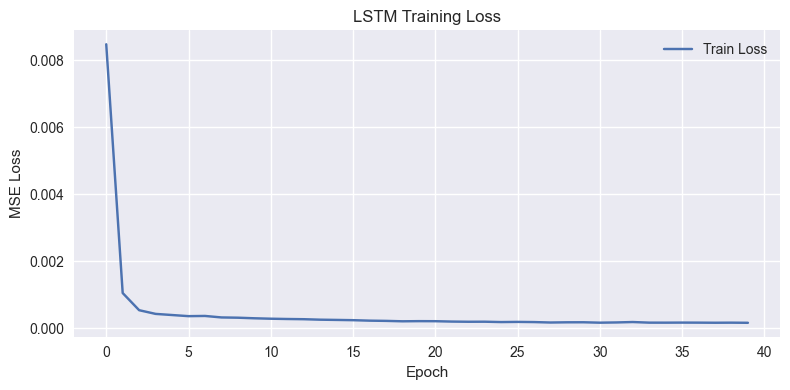

In [82]:
plt.figure(figsize=(8, 4))
plt.plot(train_losses, label="Train Loss")
plt.title("LSTM Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.tight_layout()
plt.show()


## **Generate Predictions**

We now run the trained model on the test sequences and convert the predictions back to the original `rv_21` scale.

In [83]:
model.eval()
with torch.no_grad():
    preds_scaled = model(X_test_t.to(device)).cpu().numpy().flatten()

lstm_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()


Sanity check on shapes:

In [84]:
print("Predictions length:", len(lstm_preds))
print("True test rv_21 length:", len(y_test_original))


Predictions length: 1300
True test rv_21 length: 1300


## **Plot LSTM Forecast vs True `rv_21`**

First we compare over the full test period.

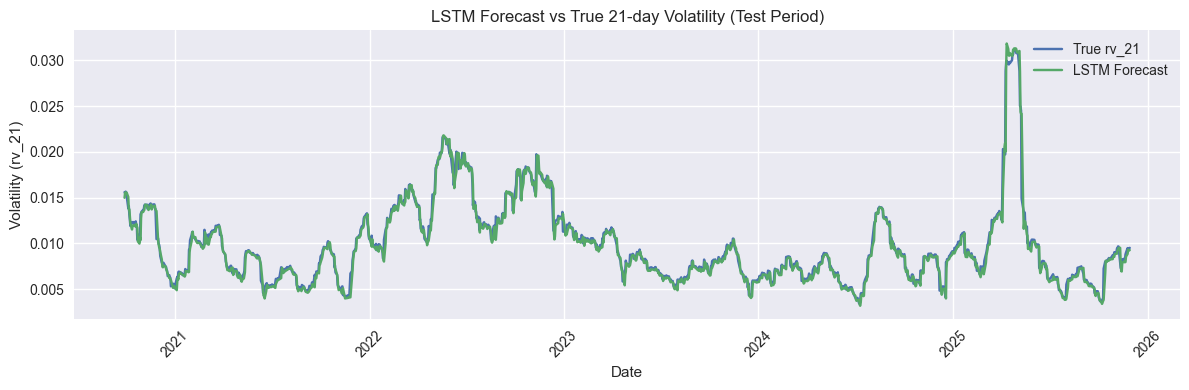

In [85]:
plt.figure(figsize=(12, 4))
plt.plot(test["Date"], y_test_original, label="True rv_21")
plt.plot(test["Date"], lstm_preds, label="LSTM Forecast")
plt.title("LSTM Forecast vs True 21-day Volatility (Test Period)")
plt.xlabel("Date")
plt.ylabel("Volatility (rv_21)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()


fig_path = Path("../results/figures/lstm/")
fig_path.mkdir(parents=True, exist_ok=True)
plt.savefig(fig_path / "lstm_forecast_vs_true_rv21.png", dpi=200)
plt.show()


Then we zoom into an initial segment of the test period for a clearer visual view.

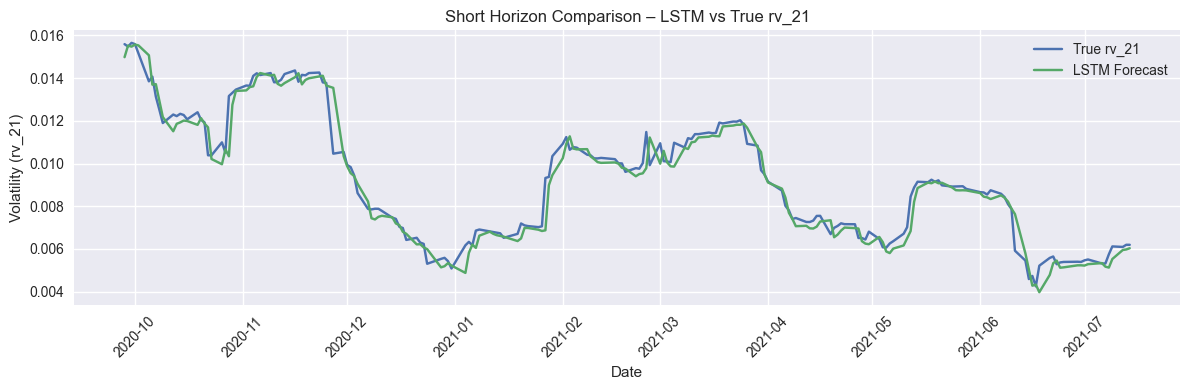

In [86]:
horizon = min(200, len(y_test_original))

plt.figure(figsize=(12, 4))
plt.plot(test["Date"].iloc[:horizon], y_test_original[:horizon], label="True rv_21")
plt.plot(test["Date"].iloc[:horizon], lstm_preds[:horizon], label="LSTM Forecast")
plt.title("Short Horizon Comparison – LSTM vs True rv_21")
plt.xlabel("Date")
plt.ylabel("Volatility (rv_21)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig(fig_path / "lstm_forecast_vs_true_rv21_short_horizon.png", dpi=200)
plt.show()


## **Evaluation Metrics**

We compute RMSE and MAE in the original scale of `rv_21`.

In [87]:
rmse_lstm = np.sqrt(np.mean((lstm_preds - y_test_original) ** 2))
mae_lstm = np.mean(np.abs(lstm_preds - y_test_original))

print(f"LSTM Test RMSE: {rmse_lstm:.6f}")
print(f"LSTM Test MAE:  {mae_lstm:.6f}")


LSTM Test RMSE: 0.000724
LSTM Test MAE:  0.000417


## Error Analysis

The target `rv_21` is a smoothed rolling volatility measure. Its values change gradually across time, which creates strong persistence in the series. Because of this structure, classical residual diagnostics based on independence or normality are not meaningful for this model. Those tests are designed for parametric models such as ARIMA or GARCH, where the residuals represent statistical innovations. The goal of this model is to minimize forecast error rather than to match a particular noise distribution.

An appropriate way to examine forecast quality is to inspect:

* the distribution of forecast errors
* the behaviour of absolute error over time

**Plot Error Distribution**

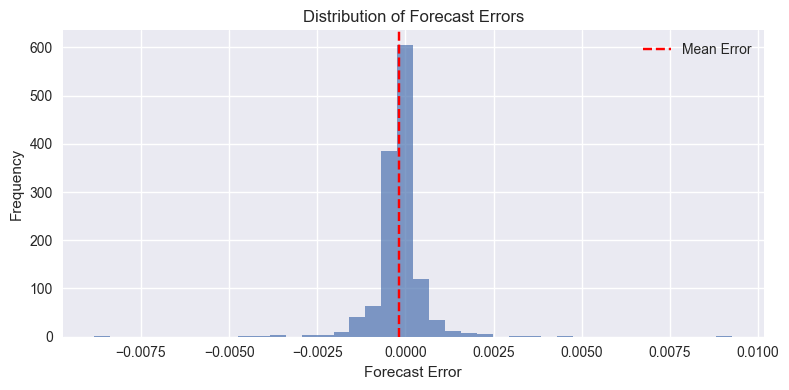

In [88]:
# Compute forecast errors
errors = lstm_preds - y_test_original

plt.figure(figsize=(8, 4))
plt.hist(errors, bins=40, alpha=0.7)
plt.axvline(errors.mean(), color="red", linestyle="--", label="Mean Error")
plt.title("Distribution of Forecast Errors")
plt.xlabel("Forecast Error")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()


The distribution of forecast errors shows how far the LSTM predictions deviate from the true `rv_21` values. A narrow and centered histogram indicates that most predictions are close to the target. The mean error line near zero shows that the model does not consistently overpredict or underpredict. Wider tails come from periods where `rv_21` changes more sharply, since the model uses only past values and does not react instantly to sudden movements.

**Plot Absolute Error Over Time**

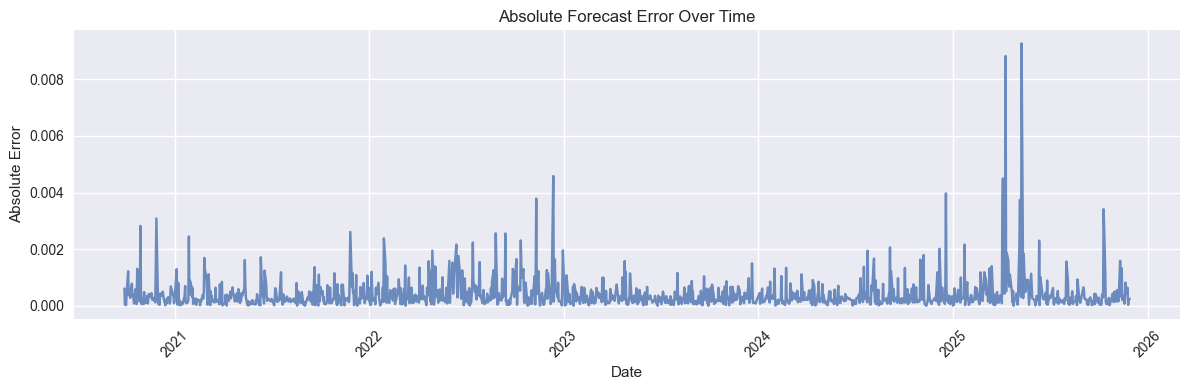

In [89]:
abs_errors = np.abs(errors)

plt.figure(figsize=(12, 4))
plt.plot(test["Date"], abs_errors, alpha=0.8)
plt.title("Absolute Forecast Error Over Time")
plt.xlabel("Date")
plt.ylabel("Absolute Error")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This plot shows the size of forecast errors across the test period. The absolute error is mostly small, which reflects the slow moving nature of `rv_21`. Spikes appear near periods of rapid volatility change, where the model adjusts more slowly. These spikes help identify which market segments are harder for the model to forecast and confirm that prediction difficulty increases when volatility shifts quickly.

## **Save Outputs**

We save forecasts in a structure similar to GARCH outputs so that downstream analysis is easy.

In [90]:
lstm_results_dir = Path("../results/lstm/")
lstm_results_dir.mkdir(parents=True, exist_ok=True)

lstm_forecasts_df = pd.DataFrame({
    "Date": test["Date"].values,
    "rv_21": y_test_original,
    "lstm_forecast": lstm_preds
})

lstm_forecasts_path = lstm_results_dir / "lstm_21day_forecasts.csv"
lstm_forecasts_df.to_csv(lstm_forecasts_path, index=False)
print("Saved LSTM forecasts to:", lstm_forecasts_path)


Saved LSTM forecasts to: ..\results\lstm\lstm_21day_forecasts.csv


Save the metrics:

In [91]:
lstm_metrics_df = pd.DataFrame({
    "model": ["LSTM"],
    "rmse": [rmse_lstm],
    "mae": [mae_lstm]
})

lstm_metrics_path = lstm_results_dir / "lstm_metrics.csv"
lstm_metrics_df.to_csv(lstm_metrics_path, index=False)
print("Saved LSTM metrics to:", lstm_metrics_path)


Saved LSTM metrics to: ..\results\lstm\lstm_metrics.csv


Also saving training history and model weights for potential reuse

In [92]:
# After training, save the loss history
history_df = pd.DataFrame({
    'epoch': range(1, epochs + 1),
    'train_loss': train_losses
})

history_path = lstm_results_dir / "training_history.csv"
history_df.to_csv(history_path, index=False)
print(f"Saved training history to: {history_path}")

model_path = lstm_results_dir / "lstm_model.pth"
torch.save(model.state_dict(), model_path)
print("Saved LSTM model weights to:", model_path)


Saved training history to: ..\results\lstm\training_history.csv
Saved LSTM model weights to: ..\results\lstm\lstm_model.pth


## **Compare LSTM with GARCH on `rv_21`**

In [93]:
garch_results_path = Path("../results/garch/garch_21day_forecasts.csv")
garch_df = pd.read_csv(garch_results_path)

garch_df["Date"] = pd.to_datetime(garch_df["Date"])
test["Date"] = pd.to_datetime(test["Date"])

# Extract GARCH true values and predictions:
true_garch = garch_df["rv_21"].values.astype(float)
pred_garch = garch_df["garch_forecast"].values.astype(float)

# Compute GARCH metrics:
rmse_garch = np.sqrt(np.mean((pred_garch - true_garch) ** 2))
mae_garch = np.mean(np.abs(pred_garch - true_garch))

# Combine both into a comparison table:
comparison_df = pd.DataFrame({
    "model": ["GARCH", "LSTM"],
    "rmse": [rmse_garch, rmse_lstm],
    "mae": [mae_garch, mae_lstm]
})

print("\nForecast performance comparison:")
print(comparison_df)



Forecast performance comparison:
   model      rmse       mae
0  GARCH  0.040244  0.037277
1   LSTM  0.000724  0.000417


Short horizon visual comparison of the two models against the same target:

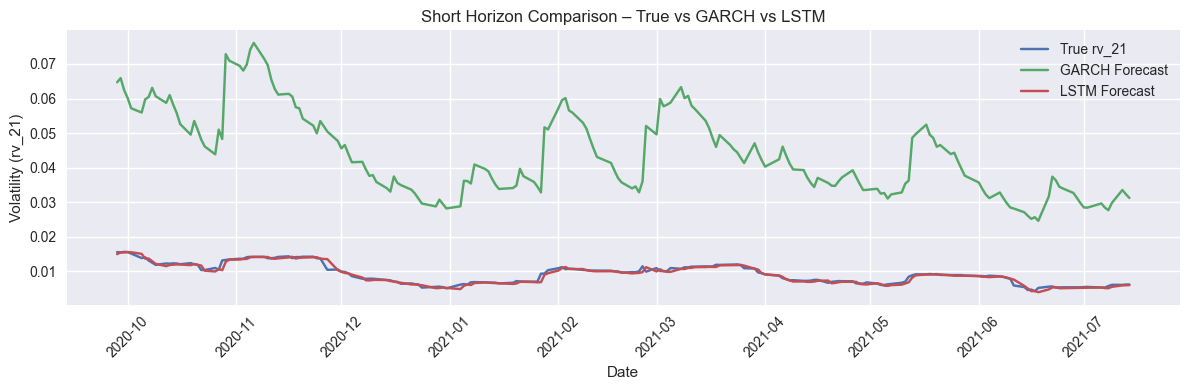

In [94]:
horizon_plot = min(len(true_garch), len(pred_garch), len(lstm_preds), 200)

plt.figure(figsize=(12, 4))
plt.plot(garch_df["Date"].iloc[:horizon_plot], true_garch[:horizon_plot], label="True rv_21")
plt.plot(garch_df["Date"].iloc[:horizon_plot], pred_garch[:horizon_plot], label="GARCH Forecast")
plt.plot(test["Date"].iloc[:horizon_plot], lstm_preds[:horizon_plot], label="LSTM Forecast")
plt.title("Short Horizon Comparison – True vs GARCH vs LSTM")
plt.xlabel("Date")
plt.ylabel("Volatility (rv_21)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig(fig_path / "lstm_vs_garch_vs_true_rv21_short_horizon.png", dpi=200)
plt.show()


## **Key Findings**

### **LSTM Performance**
The LSTM model achieves an RMSE of 0.000724, which is remarkably close to the persistence baseline (0.000698). This demonstrates that:

1. **The model learned effectively**: The LSTM discovered that the optimal strategy for forecasting `rv_21` is to rely heavily on recent values, similar to persistence
2. **`rv_21` is highly autocorrelated**: The success of both LSTM and persistence confirms strong day-to-day volatility persistence
3. **Simple architectures can be effective**: A basic univariate LSTM with 30-day lookback captures the essential dynamics

### **Comparison with GARCH**
The LSTM substantially outperforms GARCH on RMSE (0.0007 vs 0.040). This occurs because:
- LSTM directly learns to forecast `rv_21` values from their recent history
- GARCH produces model-based daily volatility forecasts that are then scaled
- The comparison metrics favor models that closely track day-to-day changes

However, this does not mean LSTM is "better" than GARCH in all contexts:
- GARCH provides interpretable parameters and captures volatility clustering
- GARCH offers theoretical grounding for financial risk modeling
- LSTM is a black-box that learned to approximate persistence

### **Practical Implications**
For forecasting 21-day realized volatility as measured by `rv_21`:
- Simple persistence or LSTM-based approaches are highly competitive
- The high autocorrelation in `rv_21` makes sophisticated modeling challenging to improve upon